Download the dataset from https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews/data

In [14]:
# Mount Google Drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
# Import necessary libraries

import numpy as np
import pandas as pd
import tensorflow as tf
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Keras utilities for text preprocessing and model building
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [16]:
# Load training and testing datasets

df_train = pd.read_csv("/content/drive/MyDrive/amazon-reviews/train.csv", skiprows=1, names=["Polarity", "Title", "Review"]) # Replace path of train dataset

df_test = pd.read_csv("/content/drive/MyDrive/amazon-reviews/test.csv", skiprows=1, names=["Polarity", "Title", "Review"]) # Replace path of test dataset



In [17]:
# Dataset preprocessing

# Remove rows with missing values
df_train.dropna(inplace=True)
df_test.dropna(inplace=True)

# Convert sentiment labels: 1 → 0 (Negative), 2 → 1 (Positive)
df_train["Polarity"] = df_train["Polarity"].astype(int) - 1
df_test["Polarity"] = df_test["Polarity"].astype(int) - 1

# Reduce training dataset size to 200K samples for efficient training
df_train = df_train.sample(200000, random_state=42)

# Extract text reviews and corresponding labels
X_train = df_train["Review"].astype(str).values
y_train = df_train["Polarity"].values
X_test = df_test["Review"].astype(str).values
y_test = df_test["Polarity"].values

<ipython-input-18-01d670b81a8d>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=["#FF6F61", "#6B8E23"])


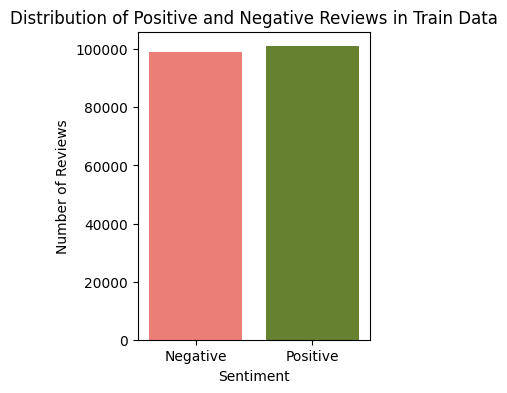

In [18]:
# Class distribution in dataset

sentiment_counts = df_train["Polarity"].value_counts()

# Plot the distribution
plt.figure(figsize=(3, 4))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette=["#FF6F61", "#6B8E23"])
plt.xticks(ticks=[0, 1], labels=["Negative", "Positive"])
plt.ylabel("Number of Reviews")
plt.xlabel("Sentiment")
plt.title("Distribution of Positive and Negative Reviews in Train Data")
plt.show()

In [19]:
# Tokenization and Padding

# Define vocabulary size and maximum review length
VOCAB_SIZE = 15000  # Restrict vocabulary to 15,000 words
MAX_LENGTH = 100    # Limit reviews to 100 words

# Initialize tokenizer with an out-of-vocabulary (OOV) token
tokenizer = Tokenizer(num_words=VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)  # Train tokenizer on review texts

# Convert text reviews into integer sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Apply padding to ensure uniform sequence length
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_LENGTH, padding="post", truncating="post")
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_LENGTH, padding="post", truncating="post")

In [20]:
# Define the LSTM model

model = Sequential([
    Embedding(VOCAB_SIZE, 32, input_length=MAX_LENGTH),
    Bidirectional(LSTM(64, return_sequences=True, dropout=0.3, recurrent_dropout=0.2)),
    LSTM(32, dropout=0.3, recurrent_dropout=0.2),
    Dense(16, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [21]:
# Train the model
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=1, min_lr=0.00001, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train,
    validation_data=(X_test_padded, y_test),
    epochs=5,
    batch_size=1024,
    callbacks=[early_stopping, lr_scheduler]
)

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 922s 5s/step - accuracy: 0.5713 - loss: 0.6624 - val_accuracy: 0.8222 - val_loss: 0.4372 - learning_rate: 0.0010
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 879s 4s/step - accuracy: 0.8262 - loss: 0.4477 - val_accuracy: 0.8168 - val_loss: 0.3909 - learning_rate: 0.0010
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.8360 - loss: 0.4202
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
196/196 ━━━━━━━━━━━━━━━━━━━━ 920s 4s/step - accuracy: 0.8360 - loss: 0.4203 - val_accuracy: 0.6643 - val_loss: 0.5821 - learning_rate: 0.0010
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 916s 4s/step - accuracy: 0.7964 - loss: 0.4502 - val_accuracy: 0.8521 - val_loss: 0.3693 - learning_rate: 5.0000e-04
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 823s 4s/step - accuracy: 0.8492 - loss: 0.3791 - val_accuracy: 0.8556 - val_loss: 0.3487 - learning_rate: 5.0000e-04


In [22]:
# Evaluate trained model on test dataset

loss, accuracy = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

# Predict sentiment on test dataset
y_pred = model.predict(X_test_padded)
y_pred_classes = (y_pred > 0.3).astype("int32")  # Conversion to binary labels

# Generate classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_classes, target_names=["Negative", "Positive"]))


12500/12500 ━━━━━━━━━━━━━━━━━━━━ 799s 64ms/step - accuracy: 0.8559 - loss: 0.3496
Test Accuracy: 85.56%
12500/12500 ━━━━━━━━━━━━━━━━━━━━ 802s 64ms/step

Classification Report:

              precision    recall  f1-score   support

    Negative       0.89      0.78      0.83    199984
    Positive       0.81      0.90      0.85    199992

    accuracy                           0.84    399976
   macro avg       0.85      0.84      0.84    399976
weighted avg       0.85      0.84      0.84    399976



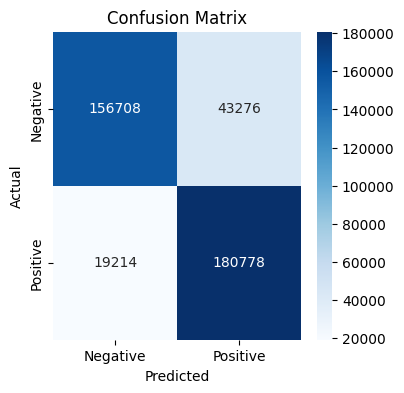

In [23]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)

# Plot confusion matrix heatmap
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Negative", "Positive"], yticklabels=["Negative", "Positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [31]:
# Example usage

def analyze_product_reviews(reviews):

    sentiment_scores = []

    for review in reviews:
        # Convert the review to a sequence
        review_seq = tokenizer.texts_to_sequences([review])
        review_padded = pad_sequences(review_seq, maxlen=MAX_LENGTH, padding="post", truncating="post")

        # Predict sentiment
        prediction = model.predict(review_padded)[0][0]
        sentiment_scores.append(prediction)

      #  print(f"Review: \"{review}\" -> Sentiment Score: {prediction:.2f}")



    # Compute average sentiment score
    avg_score = np.mean(sentiment_scores)
    print(f"\nAverage Sentiment Score: {avg_score:.2f}")  # Debugging output

    # Determine overall verdict based on average sentiment score
    if avg_score > 0.5:
        overall_sentiment = "Mostly Positive"
    elif avg_score > 0.3:
        overall_sentiment = "Mixed Sentiment"
    else:
        overall_sentiment = "Mostly Negative"

    print(f"\nOverall Verdict: {overall_sentiment} (Confidence: {avg_score:.2f})")



product_reviews = [
    "This product is fantastic! I love it.",
    "Very poor quality, broke after one use.",
    "Not great, not terrible. Just okay.",
    "Excellent! Works as expected.",
    "Terrible experience. Waste of money."
]

analyze_product_reviews(product_reviews)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step

Average Sentiment Score: 0.38

Overall Verdict: Mixed Sentiment (Confidence: 0.38)
